# Configuration Settings

Import necessary packages, classes, and functions.

In [1]:
import numpy as np
import scipy

import torch
import geoopt

from utils import MDADataset, ManifoldEmbedding, sample_negative_associations, unfold_association_matrix, process_batch

Set the device to GPU if possible.

In [2]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")

Fixing the random seed for reproducibility.

In [3]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

Set double precision for the numerical stability of the Lorentz manifold.

In [4]:
torch.set_default_dtype(torch.float64)

Ignore warnings.

In [5]:
import warnings
warnings.filterwarnings('ignore')

Set model configuration.

In [6]:
latent_dim = 256
manifold = geoopt.manifolds.Lorentz(k = 1.0, learnable=False)
ambient_dimension = 1

negative_sample_ratio = 5

num_epochs = 32
batch_size = 256
def latent_dim_to_learning_rate(latent_dim):
    return 0.001/(np.log2(latent_dim))

config_name = "Hyperboloid_" + str(latent_dim) + "latent_" + str(negative_sample_ratio) + "negatives_" + str(num_epochs) + "epochs_" + str(batch_size) + "batchsize_" + "001log2latlearningrate"

Load the association matrix.

In [7]:
association_matrix = scipy.sparse.load_npz("data/associations.npz")

# Model Fitting

Fit a model based on the configuration.

In [8]:
sampled_association_matrix = sample_negative_associations(association_matrix, negative_sample_ratio)
num_metabolites, num_diseases = sampled_association_matrix.shape
metabolites, diseases, associations = unfold_association_matrix(sampled_association_matrix)

train_dataset = MDADataset(metabolites, diseases, associations)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0, pin_memory=False, shuffle = True)

learning_rate = latent_dim_to_learning_rate(latent_dim)

metabolite_embedding_module = ManifoldEmbedding(num_metabolites, latent_dim + ambient_dimension, manifold).to(device)
disease_embedding_module = ManifoldEmbedding(num_diseases, latent_dim + ambient_dimension, manifold).to(device)

optimizer = geoopt.optim.RiemannianAdam(params=list(metabolite_embedding_module.parameters())+list(disease_embedding_module.parameters()), lr=learning_rate, stabilize=1)

for epoch in range(num_epochs):
    metabolite_embedding_module.train()
    disease_embedding_module.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        
        predicted_association, true_association = process_batch(batch, manifold, device, metabolite_embedding_module, disease_embedding_module) 

        loss = torch.nn.BCELoss(weight=torch.where(true_association<0.5, 1, negative_sample_ratio), reduction="mean")(predicted_association, true_association) 
        loss.backward()
        optimizer.step()              

Generate and save metabolite and disease embeddings.

In [9]:
metabolite_embeddings = metabolite_embedding_module(np.arange(num_metabolites)).detach().cpu().numpy()
disease_embeddings = disease_embedding_module(np.arange(num_diseases)).detach().cpu().numpy()

np.save("results/Metabolite_embeddings_" + config_name + ".npy", metabolite_embeddings)
np.save("results/Disease_embeddings_" + config_name + ".npy", disease_embeddings)

# Experiments

Import necessary plotting libraries.

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns

Load embeddings and names.

In [11]:
metabolite_embeddings = np.load("results/Metabolite_embeddings_" + config_name + ".npy")
metabolite_names = np.load("data/metabolite_names.npy")
metabolite_ids = np.load("data/metabolite_ids.npy")

disease_embeddings = np.load("results/Disease_embeddings_" + config_name + ".npy")
disease_names = np.load("data/disease_names.npy")

## Interpret Embedding Norms

Create and save Figure 2.a: Plot the degree distributions for the diseases and metabolites separately.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


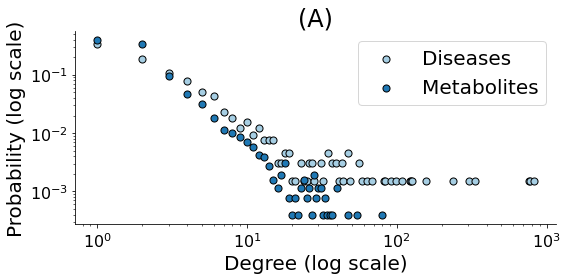

In [12]:
dis_degrees, dis_degree_numbers = np.unique(association_matrix.toarray().sum(axis=0),return_counts=True)
met_degrees, met_degree_numbers = np.unique(association_matrix.toarray().sum(axis=1),return_counts=True)

plt.figure(figsize=(8, 4))
plt.title('(A)', fontsize=24)
plt.xlabel('Degree (log scale)', fontsize = 20)
plt.ylabel('Probability (log scale)', fontsize = 20)
plt.xscale("log")
plt.yscale("log")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.scatter(dis_degrees, dis_degree_numbers / dis_degree_numbers.sum(), s=50, alpha = 1.00, label = "Diseases", c = sns.color_palette("Paired", as_cmap=False)[0], edgecolors="black")
plt.scatter(met_degrees, met_degree_numbers / met_degree_numbers.sum(), s=50, alpha = 1.00, label = "Metabolites", c = sns.color_palette("Paired", as_cmap=False)[1], edgecolors="black")
plt.legend(fontsize=20)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.savefig('results/Fig2a.jpg', dpi = 300)
plt.savefig('results/Fig2a.eps', dpi = 300)
plt.show()

Calculate the degree of certain diseases and metabolites, as well as the norm of their corresponding embeddings.

In [13]:
metabolite_norms = manifold.dist(manifold.origin(metabolite_embeddings.shape[1]), geoopt.ManifoldTensor(metabolite_embeddings, manifold=manifold))
disease_norms = manifold.dist(manifold.origin(disease_embeddings.shape[1]), geoopt.ManifoldTensor(disease_embeddings, manifold=manifold))

metabolite_degrees = association_matrix.toarray().sum(axis=1)
disease_degrees = association_matrix.toarray().sum(axis=0)

Create and save Figure 2.b: Plot the norms and the corresponding number of associations for the metabolites and diseases separately.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


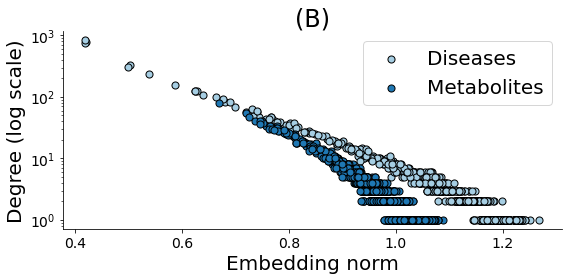

In [14]:
plt.figure(figsize=(8,4))
plt.scatter(disease_norms, disease_degrees, label="Diseases", s=50, alpha = 1.00, c = sns.color_palette("Paired", as_cmap=False)[0], edgecolors="black")
plt.scatter(metabolite_norms, metabolite_degrees, label="Metabolites", s=50, alpha = 1.00, c = sns.color_palette("Paired", as_cmap=False)[1], edgecolors="black")
plt.xlabel('Embedding norm', fontsize = 20)
plt.ylabel('Degree (log scale)', fontsize = 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale("log")
plt.title("(B)", fontsize=24)
plt.legend(fontsize=20)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.savefig('results/Fig2b.jpg', dpi = 300)
plt.savefig('results/Fig2b.eps', dpi = 300)
plt.show()

## Investigate Predictions

Select a disease.

In [15]:
disease_index = 4

known_interactions = association_matrix[:,disease_index].toarray().T[0]

print(disease_names[disease_index])
print("\tKnown positive associations: " + str(known_interactions.sum()) + "/" + str(association_matrix.shape[0]))

Alzheimer's disease
	Known positive associations: 127/2583


Predict associations between the selected disease and each metabolite.

In [16]:
predictions = 1/(1+manifold.dist(torch.Tensor(metabolite_embeddings), torch.Tensor(disease_embeddings[disease_index])).numpy())

Create and save Figure 3.a: Plot prediction histogram.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


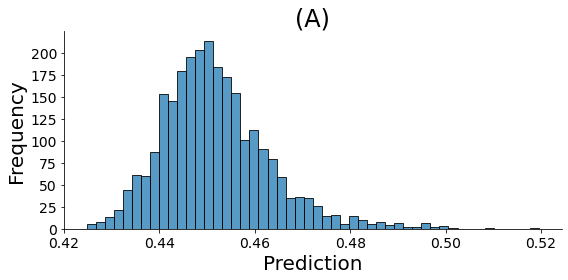

In [17]:
plt.figure(figsize=(8,4))
sns.histplot(x=predictions, color = sns.color_palette("Paired", as_cmap=False)[1], bins = 50)
plt.title("(A)", fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Prediction', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout() 
plt.savefig('results/Fig3a.jpg', dpi = 300)
plt.savefig('results/Fig3a.eps', dpi = 300)
plt.show()

Create and save Figure 3.b: Plot the number of known associations for each prediction percentile.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


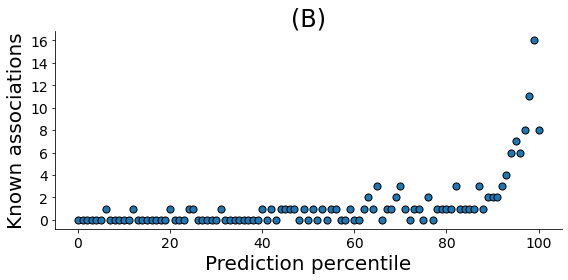

In [18]:
percentiles = scipy.stats.percentileofscore(predictions, predictions, kind='strict').round(0)
enriched_percentiles = []
enriched_sums = []
for p in np.unique(percentiles):
    enriched_percentiles.append(p)
    enriched_sums.append(known_interactions[np.where(percentiles == p)].sum())
    
plt.figure(figsize=(8,4))
plt.scatter(enriched_percentiles, enriched_sums, s=50, alpha = 1.00, c = sns.color_palette("Paired", as_cmap=False)[1], edgecolors="black")
plt.title("(B)", fontsize=24)
plt.xlabel('Prediction percentile', fontsize = 20)
plt.ylabel('Known associations', fontsize = 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout() 
plt.savefig('results/Fig3b.jpg', dpi = 300)
plt.savefig('results/Fig3b.eps', dpi = 300)
plt.show()

Fill Table 1.: List the top N predicted metabolites.

In [19]:
N = 20
topNindices = np.argsort(predictions)[-N:][::-1]
for i in topNindices:
    print(metabolite_ids[i] + "\tname:\t" + metabolite_names[i])
    print("\t\tscore:\t" + str(round(predictions[i],4)))
    print("\t\tHMDB association:\t" + str(known_interactions[i]))

HMDB0000190	name:	L-Lactic acid
		score:	0.5196
		HMDB association:	1
HMDB0000182	name:	L-Lysine
		score:	0.509
		HMDB association:	1
HMDB0000562	name:	Creatinine
		score:	0.5011
		HMDB association:	1
HMDB0000925	name:	Trimethylamine N-oxide
		score:	0.5005
		HMDB association:	0
HMDB0000122	name:	D-Glucose
		score:	0.5001
		HMDB association:	1
HMDB0000062	name:	L-Carnitine
		score:	0.4993
		HMDB association:	0
HMDB0000696	name:	L-Methionine
		score:	0.498
		HMDB association:	0
HMDB0000159	name:	L-Phenylalanine
		score:	0.497
		HMDB association:	1
HMDB0000161	name:	L-Alanine
		score:	0.4966
		HMDB association:	1
HMDB0000067	name:	Cholesterol
		score:	0.4966
		HMDB association:	0
HMDB0000517	name:	L-Arginine
		score:	0.4964
		HMDB association:	1
HMDB0000167	name:	L-Threonine
		score:	0.4961
		HMDB association:	1
HMDB0000214	name:	Ornithine
		score:	0.496
		HMDB association:	1
HMDB0000162	name:	L-Proline
		score:	0.4957
		HMDB association:	1
HMDB0000248	name:	Thyroxine
		score:	0.4957
		H